# Convolutional Neural Networks!
## 1D CNNs for musical classification

As an illustration of the development of CNNs, we'll perform classification problem on wav files representing several musical genres.

First, we'll need to convert the wav files into something that we can use, namely numpy arrays.

In [1]:
from scipy.io import wavfile
import numpy as np
import os

genres = ['blues','metal','country','hiphop']

N=len(genres)

wavlist = []
labels = []

# blues=0,metal=1,country=2,hiphop=3
for i,genre in enumerate(genres):
    files = os.listdir('datasets/genres/'+genre)
    for f in files:
        filename = 'datasets/genres/'+genre+'/'+f
        count,data = wavfile.read(filename)
        wavlist.append(data[:2**19:8]/2**15)
        labels.append(i)

y = np.array(labels)
X = np.vstack(wavlist)
print(X.shape)

(400, 65536)


Now let's plot some examples of the wave-forms

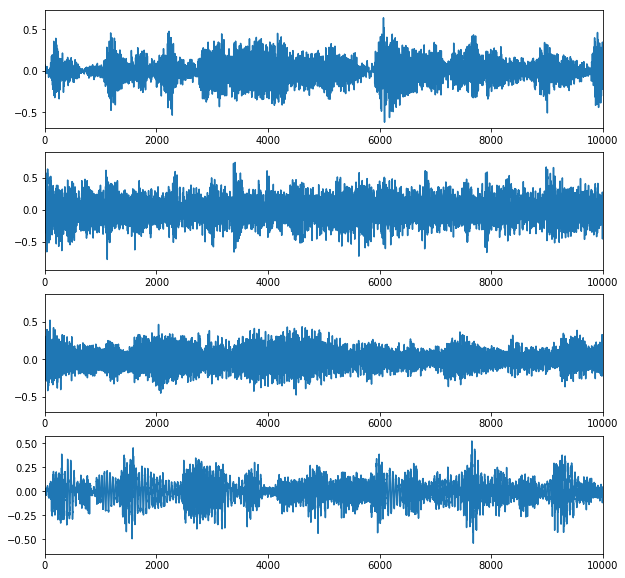

In [16]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(nrows=4,ncols=1)
fig.set_size_inches(10,10)
for ax,index in zip(axs,[0,100,200,300]):
    ax.plot(X[index,:])
    ax.set_xlim(0,10000)

plt.show()

There are definitely differences, but maybe that's just random.  What does a couple examples of metal look like?

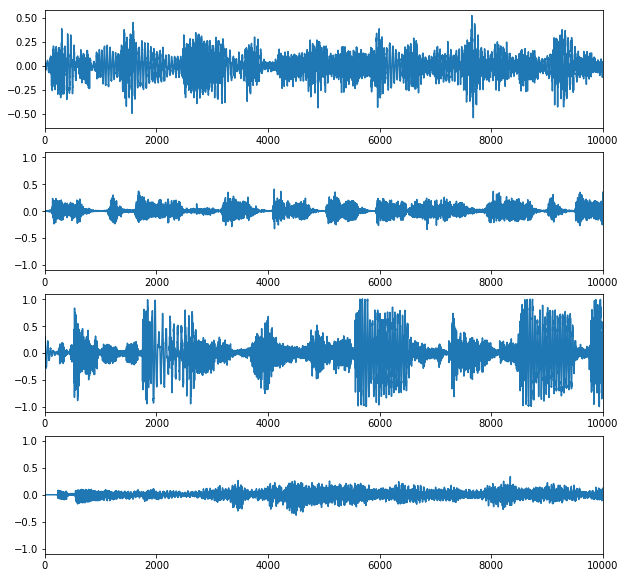

In [14]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(nrows=4,ncols=1)
fig.set_size_inches(10,10)
for ax,index in zip(axs,[300,301,302,303]):
    ax.plot(X[index,:])
    ax.set_xlim(0,10000)

plt.show()

Don't know.  We'll see if we can extract some characteristic features.  To do this, we'll learn filters which are then *convolved* over the signal.  Here's python code for a convolution, along with some examples:

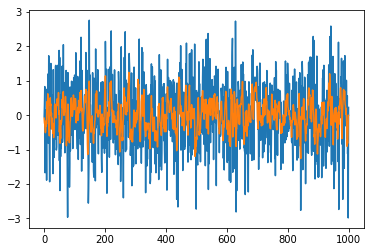

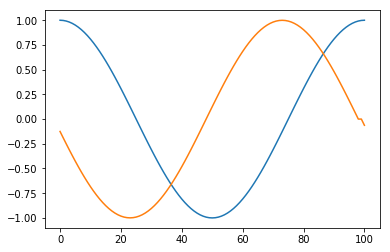

In [12]:
def convolve(X,K):
    n_kernel = len(K)
    n = len(X)
    if n_kernel%2!=1:
        print ("Must have an odd-length kernel!")
        return
    middle_kernel = int((n_kernel-1)/2)
    # Pad the edges of X
    X = np.concatenate((np.zeros((middle_kernel)),X,np.zeros((middle_kernel))))
    Z = np.zeros((n))
    for i in range(middle_kernel,n+middle_kernel-2):
        Z[i-2] = sum(X[i:i+2*middle_kernel+1]*K)
    return Z

x = np.random.randn(1000)

# Moving average kernel
K = np.ones((5))/5

z = convolve(x,K)
plt.plot(x)
plt.plot(z)
plt.show()

x = np.linspace(0,2*np.pi,101)
y = np.cos(x)
dx = 2*np.pi/100

# First derivative kernel
K = np.array([-1./(2*dx),0,1./(2*dx)])

z = convolve(y,K)
plt.plot(y)
plt.plot(z)
plt.show()



Back to songs.

Despite having relatively few examples (100 for each genre!), we'll want to ensure that our method can generalize, so let's split our data into test and training sets.  At the same time, we'll want to reshape our arrays into what Keras expects, and to form one-hot matrices with our classes.

In [17]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

X_train = X_train.reshape((*X_train.shape,1))
X_test = X_test.reshape((*X_test.shape,1))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

input_shape = (int(2**19/8),1)

print(X_train.shape,y_train.shape)

(320, 65536, 1) (320, 4)


Now we can generate our model.  What architecture should we use?  It's sort of a matter of trial and error, but I settled upon something like the following:

In [21]:
import keras
import keras.models as km
import keras.layers as kl

model = km.Sequential()

model.add(kl.Conv1D(10,kernel_size=(9,),padding='same',activation='relu',input_shape=input_shape))
model.add(kl.MaxPooling1D(pool_size=(16,),padding='same'))

model.add(kl.Conv1D(10,kernel_size=(9,),padding='same',activation='relu'))
model.add(kl.MaxPooling1D(pool_size=(16,),padding='same'))

model.add(kl.Conv1D(10,kernel_size=(9,),padding='same',activation='relu'))
model.add(kl.MaxPooling1D(pool_size=(16,),padding='same'))

model.add(kl.Flatten())
model.add(kl.Dropout(0.2))

model.add(kl.Dense(N,activation='softmax'))

The architecture for this is a convolutional layer with 10 filters (each 8 pixels wide), followed by a max-pooling layer with a kernel size of 16.  This sequence is repeated three times, reducing our input of 65536, to 16 features.  These 16 features are then fed to a softmax classifier (with each feature subject to dropout).  There is no hidden layer between the convolutional layers and the softmax layer, primarily because of our small dataset: I wanted to severely limit the number of parameters available to the model.  As it turns out, we have 80 + 80 + 80 + 64 = 304 trainable parameters in this model, which is more than enough to severely overfit in this small dataset.  Nonetheless, we'll proceed (with caution).  First we compile our model with Tensorflow, choosing categorical crossentropy as a loss function, and Adadelta (just another variant of gradient descent) as our optimizer.

In [22]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Then, we define batch sizes and epochs.  We'll look at 16 songs at a time, and we'll run the optimizer for 300 iterations.

In [23]:
batch_size = 16
epochs = 300

Finally, we can fit the model:

In [24]:
history = model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test,y_test))

Train on 320 samples, validate on 80 samples
Epoch 1/300
320/320 [==============================] - 1s 3ms/step - loss: 1.3773 - acc: 0.2438 - val_loss: 1.3398 - val_acc: 0.2875
Epoch 2/300
320/320 [==============================] - 0s 1ms/step - loss: 1.3427 - acc: 0.2875 - val_loss: 1.2973 - val_acc: 0.3625
Epoch 3/300
320/320 [==============================] - 0s 1ms/step - loss: 1.3018 - acc: 0.3125 - val_loss: 1.2475 - val_acc: 0.3875
Epoch 4/300
320/320 [==============================] - 0s 1ms/step - loss: 1.2706 - acc: 0.3875 - val_loss: 1.2243 - val_acc: 0.4250
Epoch 5/300
320/320 [==============================] - 0s 1ms/step - loss: 1.2371 - acc: 0.4469 - val_loss: 1.1975 - val_acc: 0.4500
Epoch 6/300
320/320 [==============================] - 0s 1ms/step - loss: 1.1944 - acc: 0.4812 - val_loss: 1.1778 - val_acc: 0.4875
Epoch 7/300
320/320 [==============================] - 0s 1ms/step - loss: 1.1894 - acc: 0.4219 - val_loss: 1.0987 - val_acc: 0.4375
Epoch 8/300
320/320 [===

Epoch 62/300
320/320 [==============================] - 0s 1ms/step - loss: 0.4177 - acc: 0.8375 - val_loss: 0.6281 - val_acc: 0.7250
Epoch 63/300
320/320 [==============================] - 0s 1ms/step - loss: 0.3865 - acc: 0.8625 - val_loss: 0.6819 - val_acc: 0.6875
Epoch 64/300
320/320 [==============================] - 0s 1ms/step - loss: 0.3942 - acc: 0.8531 - val_loss: 0.7202 - val_acc: 0.7000
Epoch 65/300
320/320 [==============================] - 0s 1ms/step - loss: 0.3605 - acc: 0.8687 - val_loss: 0.6252 - val_acc: 0.7250
Epoch 66/300
320/320 [==============================] - 0s 1ms/step - loss: 0.3849 - acc: 0.8531 - val_loss: 0.6198 - val_acc: 0.7250
Epoch 67/300
320/320 [==============================] - 0s 1ms/step - loss: 0.3573 - acc: 0.8719 - val_loss: 0.6265 - val_acc: 0.6875
Epoch 68/300
320/320 [==============================] - 0s 1ms/step - loss: 0.4095 - acc: 0.8375 - val_loss: 0.6486 - val_acc: 0.6875
Epoch 69/300
320/320 [==============================] - 0s 1ms

Epoch 123/300
320/320 [==============================] - 0s 1ms/step - loss: 0.1729 - acc: 0.9563 - val_loss: 0.7738 - val_acc: 0.7250
Epoch 124/300
320/320 [==============================] - 0s 1ms/step - loss: 0.1492 - acc: 0.9563 - val_loss: 0.8477 - val_acc: 0.7500
Epoch 125/300
320/320 [==============================] - 0s 1ms/step - loss: 0.2066 - acc: 0.9125 - val_loss: 0.6064 - val_acc: 0.8125
Epoch 126/300
320/320 [==============================] - 0s 1ms/step - loss: 0.1426 - acc: 0.9625 - val_loss: 0.6928 - val_acc: 0.7375
Epoch 127/300
320/320 [==============================] - 0s 1ms/step - loss: 0.1584 - acc: 0.9344 - val_loss: 0.8220 - val_acc: 0.7250
Epoch 128/300
320/320 [==============================] - 0s 1ms/step - loss: 0.1895 - acc: 0.9344 - val_loss: 0.6401 - val_acc: 0.8000
Epoch 129/300
320/320 [==============================] - 0s 1ms/step - loss: 0.1429 - acc: 0.9688 - val_loss: 0.6332 - val_acc: 0.7625
Epoch 130/300
320/320 [==============================] 

Epoch 244/300
320/320 [==============================] - 0s 1ms/step - loss: 0.0469 - acc: 0.9906 - val_loss: 0.7090 - val_acc: 0.8000
Epoch 245/300
320/320 [==============================] - 0s 1ms/step - loss: 0.0391 - acc: 0.9937 - val_loss: 0.7534 - val_acc: 0.8125
Epoch 246/300
320/320 [==============================] - 0s 1ms/step - loss: 0.0435 - acc: 0.9875 - val_loss: 0.9384 - val_acc: 0.7750
Epoch 247/300
320/320 [==============================] - 0s 1ms/step - loss: 0.0606 - acc: 0.9812 - val_loss: 0.7268 - val_acc: 0.8000
Epoch 248/300
320/320 [==============================] - 0s 1ms/step - loss: 0.0429 - acc: 0.9906 - val_loss: 0.7551 - val_acc: 0.8000
Epoch 249/300
320/320 [==============================] - 0s 1ms/step - loss: 0.0485 - acc: 0.9906 - val_loss: 0.7781 - val_acc: 0.7750
Epoch 250/300
320/320 [==============================] - 0s 1ms/step - loss: 0.0568 - acc: 0.9781 - val_loss: 0.7796 - val_acc: 0.8000
Epoch 251/300
320/320 [==============================] 

Note that we started with accuracy in both the training and test sets of 0.25: with four classes, this is the same as randomly guessing, as expected.  However, we quickly see an increase in both training and test set accuracy.  Indeed, training accuracy approaches 100%.  Is this a good thing?  Not really, since the test set accuracy (val_acc) is not keeping pace.  This is a sign of overfitting, and it's a result of using a fairly complex model on a small dataset.  Nonetheless, our test set accuracy is now doing substantially better than random, approaching accuracies of 80%.

Let's look at a plot of convergence

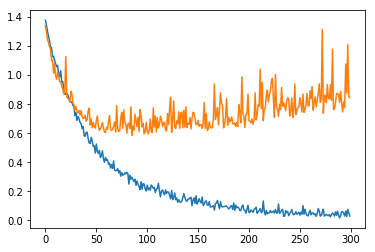

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

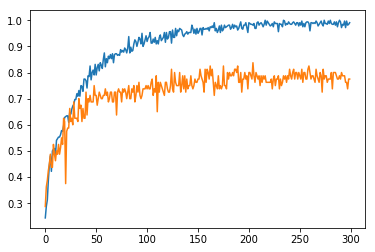

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

Not perfect, but substantially better than random!  These plots show fairly classic signs of overfitting after around epoch 50.

## 2D CNNs for all sorts of weird stuff

One of the classic examples that convolutional neural networks are used for is in image classification.  This process proceeds almost identically to what we did for songs, but this time the convolution is in 2D.  A classic test case for this classification process is the CIFAR-10 dataset: it is 60000 images worth of airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.  However, we've already done a classification problem, and it's worth noting that neural networks can be used for much more than that!  

While I was grading HW4, I got to thinking about lossy compression, and whether we could train a network to reverse that loss in some way.  Our eyes are brilliant at filling in color gaps, and maybe we can train a neural network to do the same?  What will this look like.  First, I took the CIFAR-10 dataset, and ran 8-cluster K-means based image quantization on all 60000 examples.  They look like this:

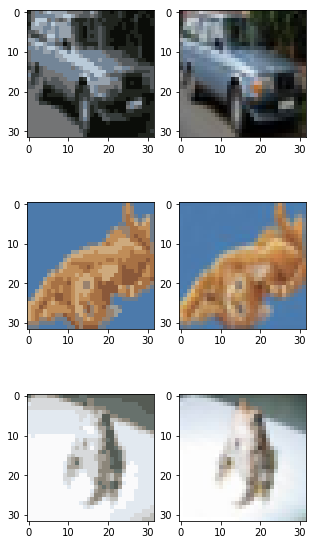

In [22]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

data_train_q, data_test_q, data_train, data_test = pickle.load(open('datasets/quantized_data.p','rb'))

fig,axs = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(5,10)

m = 10000
for i,ax in enumerate(axs):
    i = np.random.randint(m)
    ax[0].imshow((data_train_q[i].transpose(1,0,2)).astype(int))
    ax[1].imshow((data_train[i].transpose(1,0,2)).astype(int))



The idea is to train a convolutional neural network to take the quantized image, and output an unquantized one.  This isn't classification, it's more like auto-regression.  First, we'll normalize the test and training data.

In [23]:
data_train_q = data_train_q[::5]/255
data_train = data_train[::5]/255
data_test_q = data_test_q/255
data_test = data_test/255

Next, let's define a model.  We don't want to downsample, because that means we're losing more data than we've already lost, so instead we'll just hook a bunch of convolutional layers together.  Thus, we'll map from an w by h pixel image back to a w by h pixel image.   

In [24]:
input_shape = ((32,32,3))

import keras
import keras.models as km
import keras.layers as kl
from keras import backend as K

model = km.Sequential()
model.add(kl.Conv2D(128,kernel_size=(3,3),
                       padding='same',
                       activation='relu',
                       input_shape=input_shape))


model.add(kl.Conv2D(128,kernel_size=(3,3),
                       padding='same',
                       activation='relu'))



model.add(kl.Conv2D(128,kernel_size=(3,3),
                       padding='same',
                       activation='relu'))

# This final layer is a sigmoid because pixel values have to be between 0-1 (or 0 and 255 when scaled back to 8 bit)
model.add(kl.Conv2D(3,kernel_size=(3,3),
                       padding='same',
                       activation='sigmoid'))

# Note that we're using MSE rather than cross-entropy, because we're comparing float values
model.compile(loss=keras.losses.mean_squared_logarithmic_error,
              optimizer=keras.optimizers.RMSprop())


Next, let's define a batch size, number of epochs, and then fit.

In [25]:
batch_size = 256
epochs=32
history = model.fit(data_train_q, data_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(data_test_q, data_test))


Train on 10000 samples, validate on 10000 samples
Epoch 1/32
10000/10000 [==============================] - 3s 321us/step - loss: 0.0222 - val_loss: 0.0056
Epoch 2/32
10000/10000 [==============================] - 3s 294us/step - loss: 0.0079 - val_loss: 0.0075
Epoch 3/32
10000/10000 [==============================] - 3s 301us/step - loss: 0.0051 - val_loss: 0.0075
Epoch 4/32
10000/10000 [==============================] - 3s 318us/step - loss: 0.0042 - val_loss: 0.0022
Epoch 5/32
10000/10000 [==============================] - 3s 297us/step - loss: 0.0034 - val_loss: 0.0040
Epoch 6/32
10000/10000 [==============================] - 3s 291us/step - loss: 0.0029 - val_loss: 0.0021
Epoch 7/32
10000/10000 [==============================] - 3s 291us/step - loss: 0.0025 - val_loss: 0.0020
Epoch 8/32
10000/10000 [==============================] - 3s 294us/step - loss: 0.0023 - val_loss: 0.0017
Epoch 9/32
10000/10000 [==============================] - 3s 293us/step - loss: 0.0021 - val_loss: 0.0

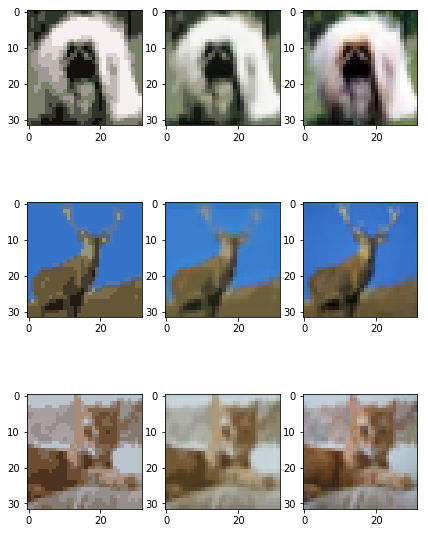

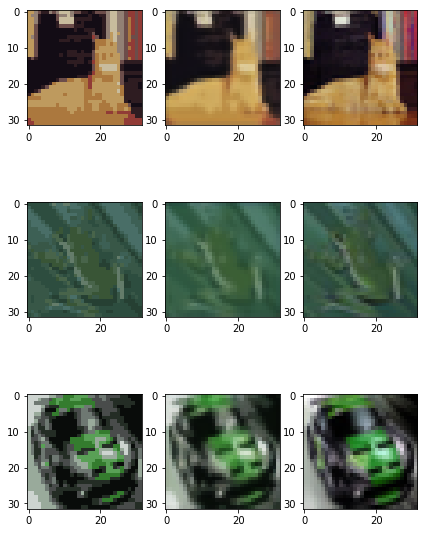

In [26]:
fig,axs = plt.subplots(nrows=3,ncols=3)
fig.set_size_inches((7,10))

p = model.predict(data_train_q)
m = 10000
for i,ax in enumerate(axs):
    i = np.random.randint(m)
    ax[0].imshow((255*data_train_q[i].transpose(1,0,2)).astype(int))
    ax[1].imshow((255*p[i].transpose(1,0,2)).astype(int).astype(int))
    ax[2].imshow((255*data_train[i].transpose(1,0,2)).astype(int))

fig,axs = plt.subplots(nrows=3,ncols=3)
fig.set_size_inches((7,10))
p = model.predict(data_test_q)

for i,ax in enumerate(axs):
    i = np.random.randint(m)
    ax[0].imshow((255*data_test_q[i].transpose(1,0,2)).astype(int))
    ax[1].imshow((255*p[i].transpose(1,0,2)).astype(int).astype(int))
    ax[2].imshow((255*data_test[i].transpose(1,0,2)).astype(int))

plt.show()

In [19]:
p

array([[[[1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
         [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
         [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
         ...,
         [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
         [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
         [1.0000000e+00, 1.0000000e+00, 1.0000000e+00]],

        [[1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
         [1.0000000e+00, 1.0000000e+00, 9.9999976e-01],
         [1.0000000e+00, 1.0000000e+00, 9.9999940e-01],
         ...,
         [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
         [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
         [1.0000000e+00, 1.0000000e+00, 1.0000000e+00]],

        [[1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
         [1.0000000e+00, 1.0000000e+00, 5.9039193e-01],
         [1.0000000e+00, 1.0000000e+00, 9.8718297e-01],
         ...,
         [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
         [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
  

In [ ]:
filt_0 = l0.get_weights()[0][:,:,0,0]
plt.imshow(filt_0)
plt.show()



In [31]:
data_train_q.shape

(10000, 32, 32, 3)

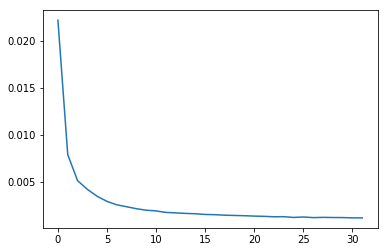

In [28]:
plt.plot(history.history['loss'])